In [16]:
import numpy as np
import pandas as pd
#test

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

from interpret.glassbox import ExplainableBoostingClassifier

data = load_breast_cancer()
data_X, y = data.data, data.target

In [2]:
X = pd.DataFrame(data=data_X, columns = data.feature_names)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=0)

In [4]:
max_number_segments_by_features = 1
ebm = ExplainableBoostingClassifier(interactions=0, max_bins=max_number_segments_by_features+2,)
ebm.fit(X_train, y_train)
ebm_global = ebm.explain_global(name='EBM')
[len(ebm_global.data(i)['scores']) for i in range(X_train.shape[1])]
        

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [5]:

def compute_binarized_features_from_ebm(X_train, y_train, X_test, max_number_segments_by_features=2,keep_negative = False):
    ebm = ExplainableBoostingClassifier(interactions=0, max_bins=max_number_segments_by_features+2)
    ebm.fit(X_train, y_train)
    ebm_global = ebm.explain_global(name='EBM')
    
    X_train_binarized = pd.DataFrame()
    X_test_binarized = pd.DataFrame()
    list_scores = []
    list_lower_threshold = []
    list_upper_threshold = []
    for i,feature_name in enumerate(ebm_global.data()['names']):
        dico_feature_i = ebm_global.data(i)
        
        number_plateau = len(ebm_global.data(i)['scores'])
        
                        
        for j in range(number_plateau):
            contrib = dico_feature_i['scores'][j]
            
            if (contrib < 0) and (not keep_negative):
                continue
            threshold_lower = dico_feature_i['names'][j] 
            threshold_upper = dico_feature_i['names'][j+1]
            
            feature_name_binarized_lower  = f'{feature_name} >= {np.round(threshold_lower,2)}'
            feature_name_binarized_upper  = f'{feature_name} < {np.round(threshold_upper,2)}'
            if j == 0:
                col_name = feature_name_binarized_upper
                X_train_binarized[col_name] = (X_train[feature_name] < threshold_upper)
                X_test_binarized[col_name] = (X_test[feature_name] < threshold_upper)
                
                list_lower_threshold.append(np.nan)
                list_upper_threshold.append(threshold_upper)
            elif j==number_plateau-1:
                col_name = feature_name_binarized_lower
                X_train_binarized[col_name] = (X_train[feature_name] >= threshold_lower)
                X_test_binarized[col_name] = (X_test[feature_name] >= threshold_lower)
                list_lower_threshold.append(threshold_lower)
                list_upper_threshold.append(np.nan)
            else:
                col_name = feature_name_binarized_lower+' and '+ feature_name_binarized_upper
                X_train_binarized[col_name] = (X_train[feature_name] < threshold_upper) & (X_train[feature_name] >= threshold_lower)
                X_test_binarized[col_name] = (X_test[feature_name] < threshold_upper) & (X_test[feature_name] >= threshold_lower)
                list_lower_threshold.append(threshold_lower)
                list_upper_threshold.append(threshold_upper)
                
            X_train_binarized[col_name] = X_train_binarized[col_name].astype(int)
                
            list_scores.append(contrib)
    df_score_feature = pd.DataFrame(index=X_train_binarized.columns, data=np.array([list_scores, list_lower_threshold, list_upper_threshold]).T, columns=['contrib', 'lower_threshold', 'upper_threshold'])
    row_intercept = pd.DataFrame(index=['intercept'], columns =df_score_feature.columns, data=[[ebm.intercept_[0],None, None]])
    df_score_feature = pd.concat([df_score_feature, row_intercept],axis=0)
            
    return X_train_binarized, X_test_binarized, df_score_feature
        


In [6]:
number_binaries_by_features = 2
keep_negative = True


X_train_binarized, X_test_binarized, df_score_feature = compute_binarized_features_from_ebm(X_train, y_train, X_test, max_number_segments_by_features=number_binaries_by_features, keep_negative = keep_negative)


In [7]:
df_score_feature

,contrib,lower_threshold,upper_threshold
mean radius < 13.38,0.118395,NaN,13.37500
mean radius >= 13.38,-0.118395,13.37500,NaN
mean texture < 18.81,0.551840,NaN,18.81000
mean texture >= 18.81,-0.551840,18.81000,NaN
mean perimeter < 86.29,-0.005638,NaN,86.29000
...,...,...,...
worst symmetry < 0.28,0.428603,NaN,0.28110
worst symmetry >= 0.28,-0.428603,0.28110,NaN
worst fractal dimension < 0.08,-0.041037,NaN,0.07993
worst fractal dimension >= 0.08,0.041037,0.07993,NaN


In [8]:
from sklearn.metrics import log_loss

def objective(trial, X_train, y_train, n_features, min_score,max_score):
    param_grid_score = {
        f"feature_{i}_score":trial.suggest_int(f"feature_{i}_score", min_score, max_score) for i in range(n_features)
    }

    param_grid_choice_feature = {
        f"feature_{i}_choice":trial.suggest_categorical(f"feature_{i}_choice", X_train.columns) for i in range(n_features)
    }

    score_intercept = trial.suggest_float("intercept", -10+min_score*n_features, 10+max_score*n_features, step=0.5)

    selected_features = [param_grid_choice_feature[f"feature_{i}_choice"] for i in range(n_features) ]

    score_vector = [param_grid_score[f"feature_{i}_score"] for i in range(n_features)]

    score_train = np.matmul(X_train[selected_features].values, np.transpose(score_vector))
    score_train_associated_probabilities = 1/(1+np.exp(-(score_train+score_intercept)))

    logloss_train = log_loss(y_train, score_train_associated_probabilities)

    return logloss_train




In [9]:
import optuna 
n_features = 3
min_score = -3
max_score = 3
optuna_objective = lambda trial : objective(trial, X_train_binarized, y_train, n_features, min_score,max_score)

# Setting the logging level WARNING, the INFO logs are suppressed.
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(
    direction="minimize",
    study_name="Score search"
)
study.optimize(optuna_objective, n_trials=300, timeout=90)

print("Number of finished trials: ", len(study.trials))
print("Best log loss:", study.best_value)

c:\Users\S5384228\Anaconda3\envs\env_scorepyo\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of finished trials:  300
Best log loss: 0.2812153112418794


In [10]:
study.best_params

{'feature_0_score': 0,
 'feature_1_score': -3,
 'feature_2_score': 3,
 'feature_0_choice': 'mean compactness < 0.09',
 'feature_1_choice': 'mean concave points >= 0.03',
 'feature_2_choice': 'worst radius < 14.96',
 'intercept': 1.5}

In [11]:
def predict_proba_score(score,intercept_score):
    proba = 1/(1+np.exp(-(score+intercept_score)))
    return proba
selected_scorepyo_features_point = [study.best_params[f'feature_{i}_score']for i in range(n_features)]
selected_scorepyo_features = [study.best_params[f'feature_{i}_choice']for i in range(n_features)]
_selected_intercept = study.best_params['intercept']

df_score_card = df_score_feature.loc[selected_scorepyo_features,:].copy()
df_score_card['point'] = selected_scorepyo_features_point

min_range_score = sum(np.clip(i,a_min=None, a_max=0) for i in df_score_card['point'].values)
max_range_score = sum(np.clip(i,a_min=0, a_max=None) for i in df_score_card['point'].values)
possible_scores = list(range(min_range_score,max_range_score+1))
possible_risks = [predict_proba_score(s,_selected_intercept) for s in possible_scores]
possible_risks_pct = [f'{r:.2%}' for r in possible_risks]
df_score_table = pd.DataFrame(index=['SCORE', 'RISK', '_RISK_FLOAT'], data = [possible_scores, possible_risks_pct, possible_risks])



In [12]:
df_score_card['Parameter'] = df_score_card.index.str.split(' ').str.slice(0,-2).str.join(' ')

df_score_card['description'] = df_score_card.index
df_score_card.index = df_score_card['Parameter']
df_score_card['feature'] = df_score_card['description'].copy()

df_score_card[['description', 'point']].sort_values(by='point')

,description,point
Parameter,,
mean concave points,mean concave points >= 0.03,-3
mean compactness,mean compactness < 0.09,0
worst radius,worst radius < 14.96,3


In [13]:
df_score_table

,0,1,2,3,4,5,6
SCORE,-3,-2,-1,0,1,2,3
RISK,18.24%,37.75%,62.25%,81.76%,92.41%,97.07%,98.90%
_RISK_FLOAT,0.182426,0.377541,0.622459,0.817574,0.924142,0.970688,0.989013


In [14]:
def predict_proba_perso(df_score_card,df_score_table_tmp, X):
    df_score_table = df_score_table_tmp.copy().T.set_index('SCORE')
    list_features = df_score_card['feature'].values
    X_selected_features = X[list_features]
    points = df_score_card['point'].values
    X_total_points = np.matmul(X_selected_features.values,points)
    proba = df_score_table.loc[X_total_points,'_RISK_FLOAT'].values.reshape(-1,1)

    return np.concatenate([1-proba,proba],axis=1)

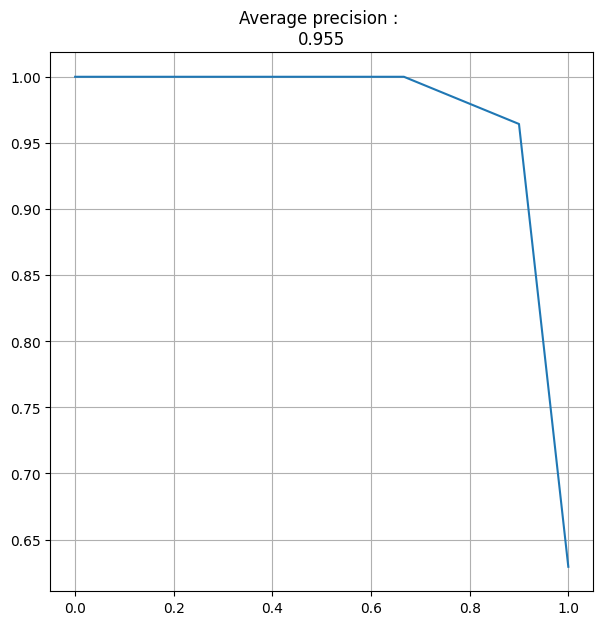

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score


y_proba = predict_proba_perso(df_score_card,df_score_table, X_test_binarized)[:, 1].reshape(-1,1)

precision, recall, thresholds = precision_recall_curve(y_test.astype(int), y_proba)
fig, ax = plt.subplots(figsize=(7, 7))
plt.plot(recall, precision)
average_precision = np.round(average_precision_score(y_test.astype(int),y_proba),3)
title_PR_curve = f'Average precision : \n{average_precision}'
plt.title(title_PR_curve)
plt.grid()
plt.show()